<a href="https://colab.research.google.com/github/Tasfiq23/Keras_DNN/blob/main/Transfer%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-09-07 02:32:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 74.125.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   154MB/s    in 1.0s    

2021-09-07 02:32:36 (154 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [23]:
#how many images in each folder
import os

#walk through 10 percent of data directory adn list number of files
for dirpath,dirnames,filenames in os.walk('/content/10_food_classes_10_percent'):
  print(f"this {dirpath} has {len(dirnames)} directories and {len(filenames)} files")
  

this /content/10_food_classes_10_percent has 2 directories and 0 files
this /content/10_food_classes_10_percent/train has 10 directories and 0 files
this /content/10_food_classes_10_percent/train/sushi has 0 directories and 75 files
this /content/10_food_classes_10_percent/train/fried_rice has 0 directories and 75 files
this /content/10_food_classes_10_percent/train/ramen has 0 directories and 75 files
this /content/10_food_classes_10_percent/train/pizza has 0 directories and 75 files
this /content/10_food_classes_10_percent/train/chicken_wings has 0 directories and 75 files
this /content/10_food_classes_10_percent/train/hamburger has 0 directories and 75 files
this /content/10_food_classes_10_percent/train/steak has 0 directories and 75 files
this /content/10_food_classes_10_percent/train/chicken_curry has 0 directories and 75 files
this /content/10_food_classes_10_percent/train/ice_cream has 0 directories and 75 files
this /content/10_food_classes_10_percent/train/grilled_salmon has 

In [24]:
# creating data loaders(preparing the data)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE =(224,224)
BATCH_SIZE = 32

train_dir= "10_food_classes_10_percent/train"
test_dir= "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale= 1/225.,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   )
test_datagen = ImageDataGenerator(rescale= 1/225.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          class_mode='categorical',
                                                          batch_size=BATCH_SIZE)

test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          class_mode='categorical',
                                                          batch_size=BATCH_SIZE)


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [25]:
#Setting up callbacks

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir= dir_name +"/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir} ")
  return tensorboard_callback


Comparing two models

efficientnet/b0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
 Restnet V2 50 :  https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [26]:
 resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
 efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [27]:
# import dependencies 

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [28]:

def create_model(model_url,num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url(str): A TensorFlow Hub feature extraction URL.
  num_classes(int): Number of output neurons in the output layer,
  should be equal to number of target classes, default 10.

  Returns:
  An incompiled Keras Sequential model with model_url as feature extractor layer
  and Dense output layer with num_classes output neurons.
  """
  #Download the pre trained model

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,#Freeze already learned patterns
                                           name ='feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE + (3,)) 
  
  #Create our own model

  model = tf.keras.Sequential([
           feature_extractor_layer,
           layers.Dense(num_classes,activation='softmax',name='output_layer')                    
  ])

  return model


In [29]:
#create Resnet model

resnet_model = create_model(resnet_url,num_classes= train_data_10_percent.num_classes)

In [30]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [31]:
#compile our resnet model

resnet_model.compile(loss= "categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [32]:
resnet_history=resnet_model.fit(train_data_10_percent ,
                 steps_per_epoch=len(train_data_10_percent ),
                 epochs=10,
                 validation_data=test_data_10_percent,
                 validation_steps=len(test_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                        experiment_name = 'resnetV250')])

Saving TensorBoard log files to : tensorflow_hub/resnetV250/20210907-023242 
Epoch 1/10
24/24 [==============================] - 34s 1s/step - loss: 1.8975 - accuracy: 0.3547 - val_loss: 1.2332 - val_accuracy: 0.6032
Epoch 2/10
24/24 [==============================] - 28s 1s/step - loss: 1.0061 - accuracy: 0.6907 - val_loss: 0.8607 - val_accuracy: 0.7320
Epoch 3/10
24/24 [==============================] - 28s 1s/step - loss: 0.7413 - accuracy: 0.7653 - val_loss: 0.7503 - val_accuracy: 0.7704
Epoch 4/10
24/24 [==============================] - 28s 1s/step - loss: 0.6319 - accuracy: 0.8040 - val_loss: 0.6929 - val_accuracy: 0.7840
Epoch 5/10
24/24 [==============================] - 28s 1s/step - loss: 0.5126 - accuracy: 0.8520 - val_loss: 0.6575 - val_accuracy: 0.7940
Epoch 6/10
24/24 [==============================] - 28s 1s/step - loss: 0.4304 - accuracy: 0.8907 - val_loss: 0.6485 - val_accuracy: 0.7952
Epoch 7/10
24/24 [==============================] - 27s 1s/step - loss: 0.3894 - ac

In [36]:
import matplotlib.pyplot as plt


def plot_loss_curves(history):

  loss= history.history['loss']
  val_loss = history.history['val_loss']

  accuracy= history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #plot loss

  plt.plot(epochs,loss,label='training_loss')
  plt.plot(epochs,val_loss,label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  
  #plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label='training_accuracy')
  plt.plot(epochs,val_accuracy,label='val_accuracy')
  plt.title('Accurcy')
  plt.xlabel('Epochs')
  plt.legend();


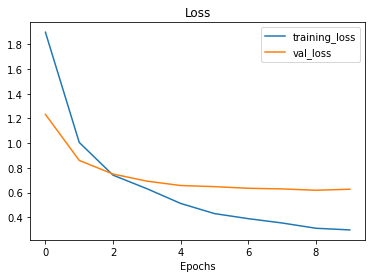

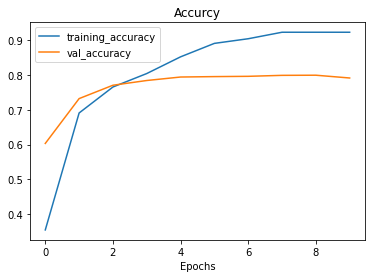

In [37]:
plot_loss_curves(resnet_history)

In [38]:
#Create a efficient net model

efficientnet_model = create_model(efficientnet_url,num_classes= train_data_10_percent.num_classes)

In [39]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [40]:
#compile our efficientnet model

efficientnet_model.compile(loss= "categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [41]:
efficientnet_history=efficientnet_model.fit(train_data_10_percent ,
                 steps_per_epoch=len(train_data_10_percent ),
                 epochs=10,
                 validation_data=test_data_10_percent,
                 validation_steps=len(test_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                        experiment_name = 'efficientnetb0')])

Saving TensorBoard log files to : tensorflow_hub/efficientnetb0/20210907-024527 
Epoch 1/10
24/24 [==============================] - 40s 1s/step - loss: 1.8418 - accuracy: 0.4307 - val_loss: 1.3162 - val_accuracy: 0.7112
Epoch 2/10
24/24 [==============================] - 32s 1s/step - loss: 1.1381 - accuracy: 0.7293 - val_loss: 0.9019 - val_accuracy: 0.8064
Epoch 3/10
24/24 [==============================] - 25s 1s/step - loss: 0.8244 - accuracy: 0.8120 - val_loss: 0.7278 - val_accuracy: 0.8352
Epoch 4/10
24/24 [==============================] - 25s 1s/step - loss: 0.7108 - accuracy: 0.8267 - val_loss: 0.6408 - val_accuracy: 0.8436
Epoch 5/10
24/24 [==============================] - 25s 1s/step - loss: 0.5989 - accuracy: 0.8600 - val_loss: 0.5863 - val_accuracy: 0.8480
Epoch 6/10
24/24 [==============================] - 24s 1s/step - loss: 0.5241 - accuracy: 0.8773 - val_loss: 0.5497 - val_accuracy: 0.8512
Epoch 7/10
24/24 [==============================] - 32s 1s/step - loss: 0.4777 

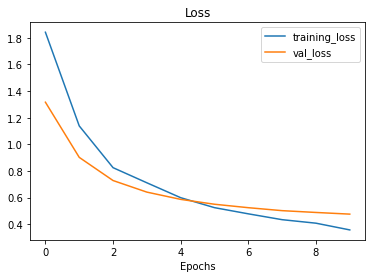

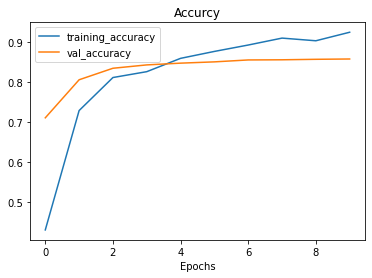

In [42]:
plot_loss_curves(efficientnet_history)